<a href="https://colab.research.google.com/github/chirucodes/aiml/blob/main/automatic_image_captioning/ImageCaptionGroup4_BaseLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Reference (GitHub):- https://github.com/hlamba28/Automatic-Image-Captioning/blob/master/Automatic%20Image%20Captioning.ipynb

In [ ]:
!rm -rf Flickr8k_Dataset.zip
!rm -rf Flickr8k_text.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip

In [3]:

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import optimizers
from keras import Input, layers
from keras.applications.inception_v3 import preprocess_input
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [4]:
# from keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop


In [5]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/content/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [8]:
len(doc), type(doc)

(3395237, str)

In [20]:
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [29]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping


In [24]:
#image_id
doc.split('\n')[0].split()[0].split('.')[0]

'1000268201_693b08cb0e'

In [27]:
#image_desc
' '.join(doc.split('\n')[0].split()[1:])

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [30]:
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [33]:
#images
print(len(descriptions.keys()))
print(descriptions.keys())

8092
dict_keys(['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a', '101654506_8eb26cfb60', '101669240_b2d3e7f17b', '1016887272_03199f49c4', '1019077836_6fc9b15408', '1019604187_d087bf9a5f', '1020651753_06077ec457', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '1022975728_75515238d8', '102351840_323e3de834', '1024138940_f1fefbdce1', '102455176_5f8ead62d5', '1026685415_0431cbf574', '1028205764_7e8df9a2ea', '1030985833_b0902ea560', '103106960_e8a41d64f8', '103195344_5d2dc613a3', '103205630_682ca7285b', '1032122270_ea6f0beedb', '1032460886_4a598ed535', '1034276567_49bb87c51c', '104136873_5b5d41be75', '1042020065_fb3d3ba5ba', '1042590306_95dea0916c', '1045521051_108ebc19be', '1048710776_bb5b0a5c7c', '1052358063_eae6744153', '105342180_4d4a40b47f', '1053804096_ad278b25f1', '1055623002_8195a4

In [34]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [43]:
descriptions['10815824_2997e03d76']

['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .',
 'A girl and her horse stand by a fire .',
 "A girl holding a horse 's lead behind a fire .",
 'A man , and girl and two horses are near a contained fire .',
 'Two people and two horses watching a fire .']

In [44]:
table = str.maketrans('', '', string.punctuation)

In [45]:
descriptions['10815824_2997e03d76'][2].split()

['A',
 'girl',
 'holding',
 'a',
 'horse',
 "'s",
 'lead',
 'behind',
 'a',
 'fire',
 '.']

In [46]:
desc = [w.translate(table) for w in descriptions['10815824_2997e03d76'][2].split()]

In [47]:
desc

['A', 'girl', 'holding', 'a', 'horse', 's', 'lead', 'behind', 'a', 'fire', '']

In [48]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [49]:
descriptions['10815824_2997e03d76'][2]


'girl holding horse lead behind fire'

In [69]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [72]:
#DUPLICATE OF THE ABOVE BLOCK 

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	# for checking the complete list of vocab
    all_desc_list_duplicate = list()
    all_desc = set()
    for key in descriptions.keys():
        [all_desc_list_duplicate.extend(d.split()) for d in descriptions[key]]
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc, all_desc_list_duplicate

# summarize vocabulary
vocabulary, vocabulary_list_duplicate = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))
print('Original Vocabulary Size: %d' % len(vocabulary_list_duplicate))


Original Vocabulary Size: 8763
Original Vocabulary Size: 372935


In [77]:
type(descriptions), list(descriptions.keys())[:5]

(dict,
 ['1000268201_693b08cb0e',
  '1001773457_577c3a7d70',
  '1002674143_1b742ab4b8',
  '1003163366_44323f5815',
  '1007129816_e794419615'])

In [81]:
"""
1000268201_693b08cb0e child in pink dress is climbing up set of stairs in an entry way
1000268201_693b08cb0e girl going into wooden building
1000268201_693b08cb0e little girl climbing into wooden playhouse
1000268201_693b08cb0e little girl climbing the stairs to her playhouse
1000268201_693b08cb0e little girl in pink dress going into wooden cabin
1001773457_577c3a7d70 black dog and spotted dog are fighting
"""

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')


In [82]:

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '/content/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [88]:
list(train)[:10]

['544122267_e9e0100bc5',
 '493507605_48fe8e3739',
 '357191373_a1cb5696e8',
 '2707244524_d57120d74a',
 '3634281981_d9cf1d1a33',
 '3474265683_43b1033d94',
 '3444982197_0ff15cc50b',
 '1303335399_b3facd47ab',
 '3130064588_6d1d3fa2dd',
 '477768471_d7cd618fdb']

In [89]:
# Below path contains all the images
images = '/content/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [91]:
type(img), img[:5]

(list,
 ['/content/Flicker8k_Dataset/3079341641_f65f6b0f8b.jpg',
  '/content/Flicker8k_Dataset/489773343_a8aecf7db3.jpg',
  '/content/Flicker8k_Dataset/2428959030_bdffc2812e.jpg',
  '/content/Flicker8k_Dataset/2230067846_74046b89d3.jpg',
  '/content/Flicker8k_Dataset/241346471_c756a8f139.jpg'])

In [92]:
# Below file conatains the names of images to be used in train data
train_images_file = '/content/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))


In [94]:
list(train_images)[:5]

['2651915425_7a58e862e9.jpg',
 '2279945145_8815c59217.jpg',
 '2218743570_9d6614c51c.jpg',
 '2995935078_beedfe463a.jpg',
 '437917001_ae1106f34e.jpg']

In [100]:
#i[len(images):] in train_images
# train_images
images, len(images), img[0][len(images):]
# img[0][]

('/content/Flicker8k_Dataset/', 27, '3079341641_f65f6b0f8b.jpg')

In [101]:

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [103]:
len(train_img), train_img[:5]

(6000,
 ['/content/Flicker8k_Dataset/3079341641_f65f6b0f8b.jpg',
  '/content/Flicker8k_Dataset/489773343_a8aecf7db3.jpg',
  '/content/Flicker8k_Dataset/2428959030_bdffc2812e.jpg',
  '/content/Flicker8k_Dataset/2230067846_74046b89d3.jpg',
  '/content/Flicker8k_Dataset/241346471_c756a8f139.jpg'])

In [104]:
# Below file conatains the names of images to be used in test data
test_images_file = '/content/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [105]:
len(test_img), test_img[:5]

(1000,
 ['/content/Flicker8k_Dataset/3364026240_645d533fda.jpg',
  '/content/Flicker8k_Dataset/1659358141_0433c9bf99.jpg',
  '/content/Flicker8k_Dataset/2311690895_0d6efe11c8.jpg',
  '/content/Flicker8k_Dataset/1982852140_56425fa7a2.jpg',
  '/content/Flicker8k_Dataset/2333288869_8c01e4c859.jpg'])

In [106]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [109]:
list(train_descriptions.keys())[:5], train_descriptions['1000268201_693b08cb0e']

(['1000268201_693b08cb0e',
  '1001773457_577c3a7d70',
  '1002674143_1b742ab4b8',
  '1003163366_44323f5815',
  '1007129816_e794419615'],
 ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'])

In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    # from keras.preprocessing import image

    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 455.5986330509186


In [ ]:
pkl_train_file="/content/sample_data/Pickle/encoded_train_images.pkl"

In [ ]:
# Save the bottleneck train features to disk
with open(pkl_train_file, "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

    # /content/sample_data/Pickle/encoded_train_images.pkl

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 74.8091504573822


In [ ]:
pkl_test_file = "/content/sample_data/Pickle/encoded_test_images.pkl"

In [ ]:

# Save the bottleneck test features to disk
with open(pkl_test_file, "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [ ]:
train_features = load(open(pkl_train_file, "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-06-25 17:49:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-06-25 17:49:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-25 17:49:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.200d.zip

In [ ]:

# Load Glove vectors
glove_dir = '/content/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1652, 200)

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 3
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


2000/2000 [==============================] - 198s 99ms/step - loss: 3.2079


In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

   1/2000 [..............................] - ETA: 4:11 - loss: 3.1619

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2000/2000 [==============================] - 199s 100ms/step - loss: 2.9062


In [ ]:
model.optimizer.lr = 0.0001
epochs = 3
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

   1/2000 [..............................] - ETA: 3:34 - loss: 2.8499

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2000/2000 [==============================] - 197s 98ms/step - loss: 2.7081


In [ ]:

model.save_weights('./model_weights/model_30.h5')

In [ ]:
model.load_weights('./model_weights/model_30.h5')

In [ ]:
images = '/content/Flicker8k_Dataset/'

In [ ]:
with open(pkl_test_file, "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

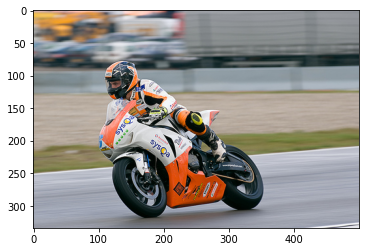

Greedy: motorcycle racer is riding on racetrack


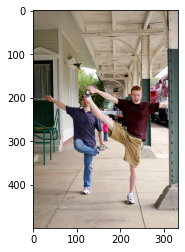

Greedy: woman in pink dress is walking down the street


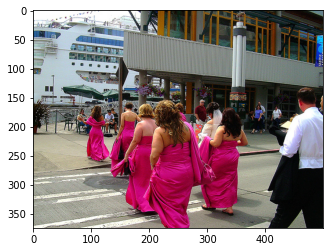

Greedy: group of people are standing in front of building


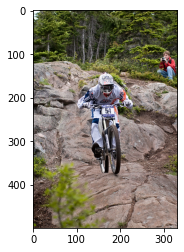

Greedy: man on bike is riding his bike through the woods


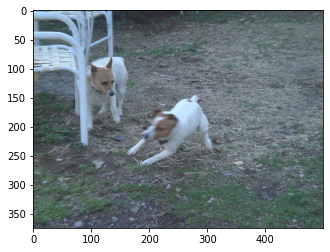

Greedy: two dogs are running through the grass


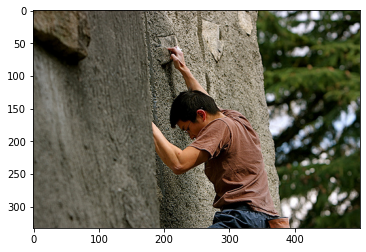

Greedy: man in red shirt and jeans climbs rock face


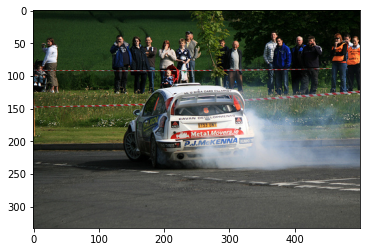

Greedy: race car driver is driving around track


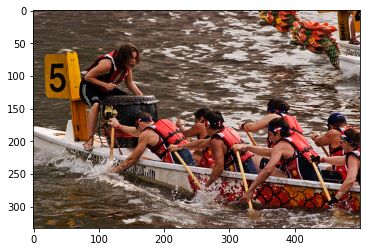

Greedy: two people are in the water


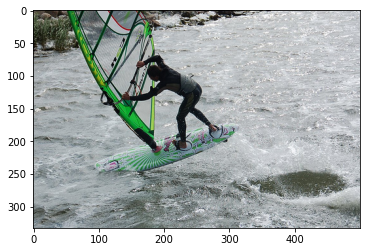

Greedy: man in red shirt is climbing up large rock


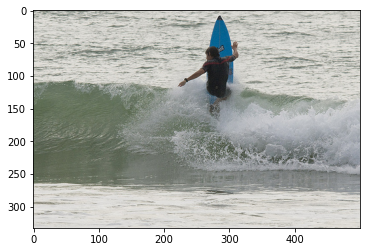

Greedy: man in black wetsuit is surfing


In [ ]:
for z in range(10):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(image))